# AMLB shorter runs visualizations

In [1]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import Orange

from visualization_early import FRAMEWORK_TO_COLOR
from data_processing import get_print_friendly_name, impute_missing_results, calculate_ranks, is_old

In [2]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures" / "CD"
FIGURE_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [3]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results["framework"] = results["framework"].apply(get_print_friendly_name)

In [4]:
from IPython.display import display

with pd.option_context("display.max_rows", None):
    display(results.groupby(by=["constraint", "framework"]).size())

constraint              framework            
Mixed Time Constraints  AutoGluon(B)_10min       1040
                        AutoGluon(B)_30min       1040
                        AutoGluon(B)_5min        1040
                        AutoGluon(B)_60min       1040
                        AutoGluon(HQ)_10min      1040
                        AutoGluon(HQ)_30min      1040
                        AutoGluon(HQ)_5min       1040
                        AutoGluon(HQ)_60min      1040
                        AutoGluon(HQIL)_10min    1040
                        AutoGluon(HQIL)_30min    1040
                        AutoGluon(HQIL)_5min     1040
                        AutoGluon(HQIL)_60min    1040
                        CP_60min                 1040
                        FEDOT_10min              1040
                        FEDOT_30min              1040
                        FEDOT_5min               1040
                        FEDOT_60min              1040
                        GAMA(B)_10mi

# Distributon plot

In [5]:
name_mapping = {
    'constantpredictor_60min': 'CP_60min',
    'RandomForest_60min': 'RF_60min',
    'TunedRandomForest_60min': 'TRF_60min'
}

### Correlation among frameworks

In [6]:
strings_by_time = ['_5min', '_10min', '_30min', '_60min']
extra_frameworks = ['RF_60min', 'TRF_60min', 'CP_60min']

In [7]:
total_dictionary = dict()
for name_time in strings_by_time:
    print("This is the time constraint", name_time)
    for task in results.task.unique():
        this_dataframe = results[results['framework'].str.contains(name_time) | results['framework'].isin(extra_frameworks)]
        this_dataframe = this_dataframe.loc[this_dataframe['task'] == task]
        this_dataframe['framework'] = this_dataframe['framework'].apply(lambda x: name_mapping.get(x, x))
        data = this_dataframe.copy()
        data = impute_missing_results(data, with_results_from="CP_60min")
        data['framework'] = data['framework'].apply(lambda x: x.replace(name_time, ''))
        data['framework'] = data['framework'].apply(lambda x: x.replace("_60min", ''))
        data = data[data['framework'] != 'CP']
        ranks = calculate_ranks(data)
        total_dictionary[(name_time.replace("_",""), task)] = ranks

This is the time constraint _5min
This is the time constraint _10min
This is the time constraint _30min
This is the time constraint _60min


### Correlation(task, constraint_1, constraint_2)

C:\Users\20210595\AppData\Local\Temp\ipykernel_4664\3731244938.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['Correlation'], shade=True, color=color, alpha=0.2, label=f'{time1} vs {time2}')
C:\Users\20210595\AppData\Local\Temp\ipykernel_4664\3731244938.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['Correlation'], shade=True, color=color, alpha=0.2, label=f'{time1} vs {time2}')
C:\Users\20210595\AppData\Local\Temp\ipykernel_4664\3731244938.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['Correlation'], shade=True, color=color, alpha=0.2, label=f'{time1} vs {time2}')


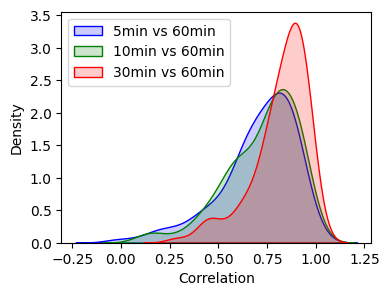

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Extract Data
data_dict = {}
for (time, task), ranks in total_dictionary.items():
    if time not in data_dict:
        data_dict[time] = {}
    data_dict[time][task] = ranks

# Step 2: Calculate Correlations
correlation_data = []
time_pairs = [('5min', '60min'), ('10min', '60min'), ('30min', '60min')]
for time1, time2 in time_pairs:
    tasks = set(data_dict[time1].keys()).intersection(data_dict[time2].keys())
    for task in tasks:
        ranks_time1 = pd.Series(data_dict[time1][task])
        ranks_time2 = pd.Series(data_dict[time2][task])
        correlation = ranks_time1.corr(ranks_time2)
        correlation_data.append({'Time1': time1, 'Time2': time2, 'Task': task, 'Correlation': correlation})

# Step 3: Prepare DataFrame
correlation_df = pd.DataFrame(correlation_data)

# Step 4: Plot Density Distributions
plt.figure(figsize=(4, 3))
colors = ['blue', 'green', 'red']
for (time1, time2), color in zip(time_pairs, colors):
    subset = correlation_df[(correlation_df['Time1'] == time1) & (correlation_df['Time2'] == time2)]
    sns.kdeplot(subset['Correlation'], shade=True, color=color, alpha=0.2, label=f'{time1} vs {time2}')

#plt.title('Density Plot of Correlations by Time Constraint Pairs')
plt.xlabel('Correlation')
plt.ylabel('Density')

# Position the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(loc='upper left')

# Save the figure
plt.savefig(FIGURE_DIRECTORY / 'density_plot_general.png', bbox_inches='tight', dpi=300)

plt.show()

### Correlation based on dataset size (instances/rows)

In [11]:
import openml
from openml.tasks import OpenMLRegressionTask

In [12]:
def is_dataset_imbalanced(dataset_qualities, threshold=1.5):
    """
    Determine if the dataset is imbalanced based on the given threshold.
    
    Parameters:
    - dataset_qualities (dict): Dictionary containing dataset qualities.
    - threshold (float): Threshold for determining imbalance. Default is 1.5.
    
    Returns:
    - bool: True if the dataset is imbalanced, False otherwise.
    """
    majority_class_percentage = dataset_qualities.get('MajorityClassPercentage')
    minority_class_percentage = dataset_qualities.get('MinorityClassPercentage')
    
    if majority_class_percentage is None or minority_class_percentage is None:
        raise ValueError("MajorityClassPercentage or MinorityClassPercentage is missing in dataset qualities.")
    
    # Calculate the imbalance ratio
    imbalance_ratio = majority_class_percentage / minority_class_percentage
    
    # Determine if the dataset is imbalanced
    return imbalance_ratio > threshold

In [13]:
ids_string = results.id.unique()
# ids = [element.replace("openml.org/t/", "") for element in ids_string]
list_binary = []
list_multiclass = []
list_regression = []
percentage_numeric_feature = []
imbalance_dataset = []
balance_dataset = []
dataset_ids = dict()
dataset_ids_instances = dict()
dataset_ids_features = dict()
for task_id in results.id.unique():
    name_task = results[results['id']==task_id].task.unique()[0]
    task_id = task_id.replace("openml.org/t/", "")
    task = openml.tasks.get_task(task_id)
    # if task.PercentageOfNumericFeatures >50:
    #    percentage_numeric_feature.append(name_task)
    dataset_id = task.dataset_id
    dataset = openml.datasets.get_dataset(dataset_id, download_data = False)
    dataset_ids[name_task] = dataset_id
    dataset_ids_instances[name_task] = dataset.qualities['NumberOfInstances']
    dataset_ids_features[name_task] = dataset.qualities['NumberOfFeatures']
    if isinstance(task, OpenMLRegressionTask):
        list_regression.append(name_task)
    elif len(task.class_labels) == 2:
        list_binary.append(name_task)
        if is_dataset_imbalanced(dataset.qualities):
            imbalance_dataset.append(name_task)
        else:
            balance_dataset.append(name_task)
    else:
        list_multiclass.append(name_task)
        if is_dataset_imbalanced(dataset.qualities):
            imbalance_dataset.append(name_task)
        else:
            balance_dataset.append(name_task)


C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\IPython\core\interactiveshell.py:3550: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\IPython\core\interactiveshell.py:3550: FutureWarning: Task id must be specified as `int` from 0.14.0 onwards.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\openml\tasks\functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `downlo

In [14]:
# Identify the item with the lowest value
lowest_item = min(dataset_ids_instances.items(), key=lambda x: x[1])

# Identify the item with the highest value
highest_item = max(dataset_ids_instances.items(), key=lambda x: x[1])

# Print the result
print(f"The item with the lowest value is: {lowest_item[0]} with a value of {lowest_item[1]}")
# Print the result
print(f"The item with the highest value is: {highest_item[0]} with a value of {highest_item[1]}")

The item with the lowest value is: arcene with a value of 100.0
The item with the highest value is: Airlines_DepDelay_10M with a value of 10000000.0


In [15]:
# Initialize the lists
smallest_to_half = []
half_to_largest = []

# Categorize the keys based on their values
for key, value in dataset_ids_instances.items():
    if value < 10000:
        smallest_to_half.append(key)
    else:
        half_to_largest.append(key)

In [16]:
correlation_df

,Time1,Time2,Task,Correlation
0,5min,60min,covertype,0.864286
1,5min,60min,connect-4,0.796429
2,5min,60min,numerai28_6,0.885714
3,5min,60min,wine_quality,0.678441
4,5min,60min,abalone,0.714545
...,...,...,...,...
307,30min,60min,ozone-level-8hr,0.617857
308,30min,60min,Bioresponse,0.850000
309,30min,60min,fabert,0.760714
310,30min,60min,bank-marketing,0.942857


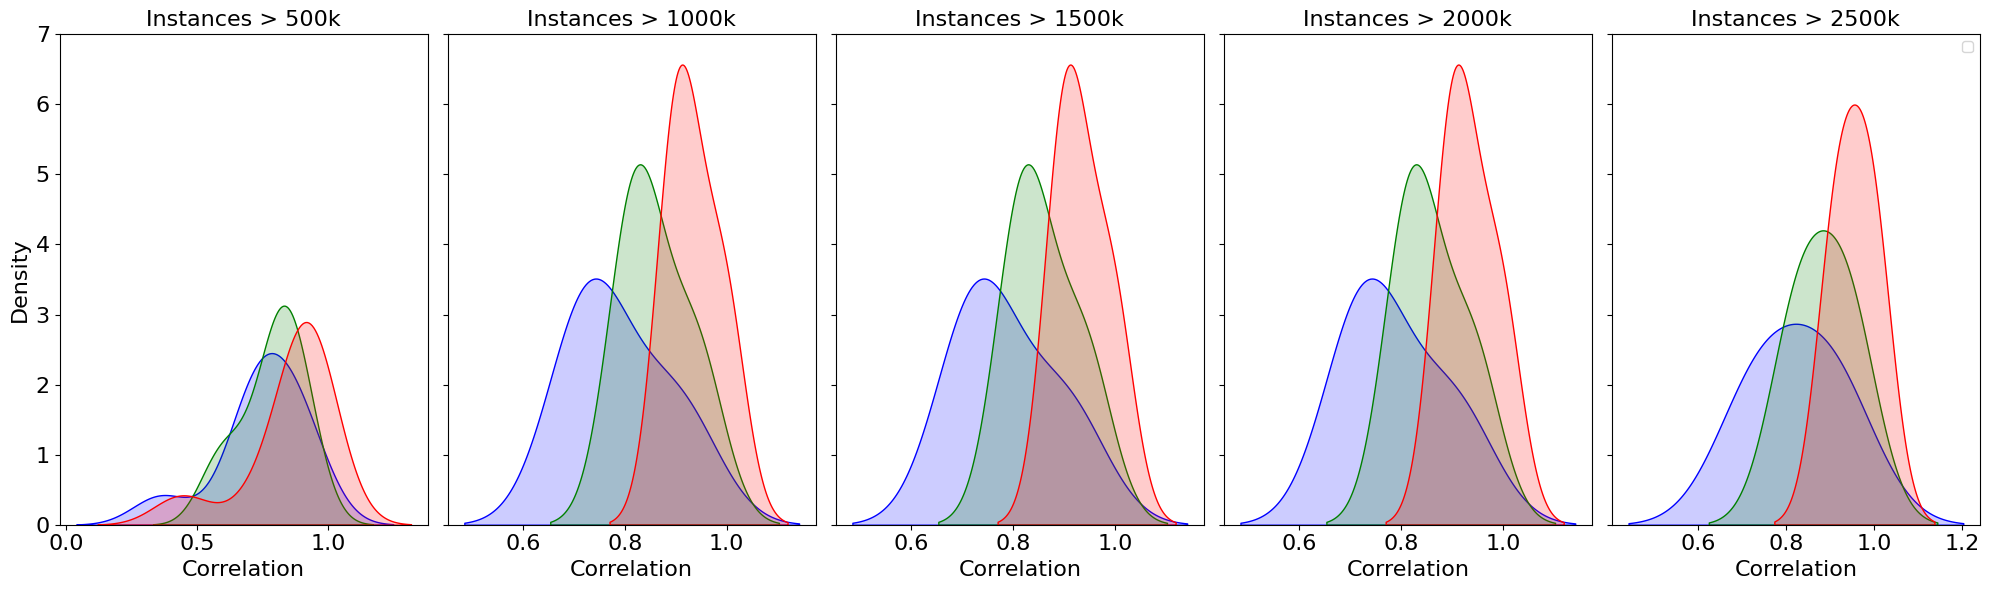

In [17]:
# Number of steps
steps = 5

# Create subplots
fig, axes = plt.subplots(1, steps, figsize=(20, 6), sharey=True)

for i, step in enumerate([500000 * (i + 1) for i in range(steps)]):
# for i, step in enumerate([500000, 1000000, 3000000, 5000000, 7000000]):
    smallest_to_half = []
    half_to_largest = []
    
    # Categorize the keys based on their values
    for key, value in dataset_ids_instances.items():
        if value > step:
            smallest_to_half.append(key)
        else:
            half_to_largest.append(key)
    
    # Filter the DataFrame
    correlation_small = correlation_df[correlation_df['Task'].isin(smallest_to_half)]
    
    # Plot Density Distributions
    colors = ['blue', 'green', 'red']
    for (time1, time2), color in zip(time_pairs, colors):
        subset = correlation_small[(correlation_small['Time1'] == time1) & (correlation_small['Time2'] == time2)]
        sns.kdeplot(subset['Correlation'], fill=True, color=color, alpha=0.2, label=f'{time1} vs {time2}' if i == steps - 1 else "", ax=axes[i])

    new_step = int(step/1000)
    axes[i].set_title(f'Instances > {new_step}k', fontsize=16)
    axes[i].set_xlabel('Correlation', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    if i == 0:
        axes[i].set_ylabel('Density', fontsize=16)
    else:
        axes[i].set_ylabel('')
    
    # Position the legend outside the plot only for the last subplot
    if i == steps - 1:
        # axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=16)
        axes[i].legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', borderaxespad=0., fontsize=16)
plt.legend([]) # turn off legends
plt.ylim(0, 7)
plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY / 'density_plot_over_instances.png', bbox_inches='tight', dpi=300)
plt.show()

#### Dimensionality

In [18]:

# Identify the item with the lowest value
lowest_item = min(dataset_ids_features.items(), key=lambda x: x[1])

# Identify the item with the highest value
highest_item = max(dataset_ids_features.items(), key=lambda x: x[1])

# Print the result
print(f"The item with the lowest value is: {lowest_item[0]} with a value of {lowest_item[1]}")
# Print the result
print(f"The item with the highest value is: {highest_item[0]} with a value of {highest_item[1]}")

The item with the lowest value is: quake with a value of 4.0
The item with the highest value is: KDDCup09-Upselling with a value of 14892.0


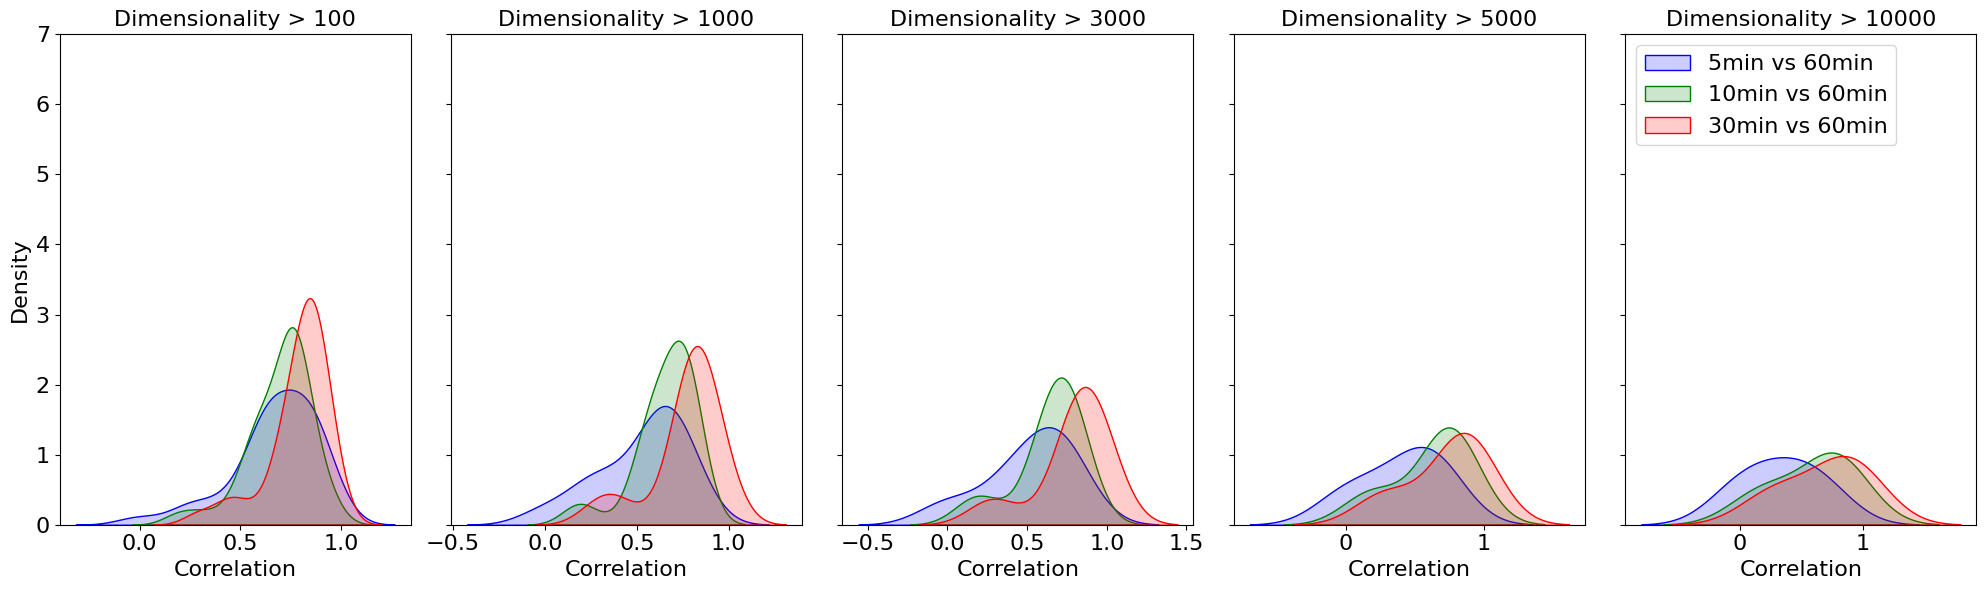

In [19]:
# Number of steps
steps = 5

# Create subplots
fig, axes = plt.subplots(1, steps, figsize=(20, 6), sharey=True)

#for i, step in enumerate([2000 * (i + 1) for i in range(steps)]):
for i, step in enumerate([100, 1000, 3000, 5000, 10000]):
    smallest_to_half = []
    half_to_largest = []
    
    # Categorize the keys based on their values
    for key, value in dataset_ids_features.items():
        if value > step:
            smallest_to_half.append(key)
        else:
            half_to_largest.append(key)
    
    # Filter the DataFrame
    correlation_small = correlation_df[correlation_df['Task'].isin(smallest_to_half)]
    
    # Plot Density Distributions
    colors = ['blue', 'green', 'red']
    for (time1, time2), color in zip(time_pairs, colors):
        subset = correlation_small[(correlation_small['Time1'] == time1) & (correlation_small['Time2'] == time2)]
        sns.kdeplot(subset['Correlation'], fill=True, color=color, alpha=0.2, label=f'{time1} vs {time2}' if i == steps - 1 else "", ax=axes[i])
    
    axes[i].set_title(f'Dimensionality > {step}', fontsize=16)
    axes[i].set_xlabel('Correlation', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    if i == 0:
        axes[i].set_ylabel('Density', fontsize=16)
    else:
        axes[i].set_ylabel('')
    
    # Position the legend outside the plot only for the last subplot
    if i == steps - 1:
        # axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=16)
        # axes[i].legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', borderaxespad=0., fontsize=16)
        axes[i].legend(loc='upper left', fontsize=16)
plt.ylim(0, 7)
plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY / 'density_plot_over_features.png', bbox_inches='tight', dpi=300)
plt.show()

#### Per type, binary, multiclass and regression

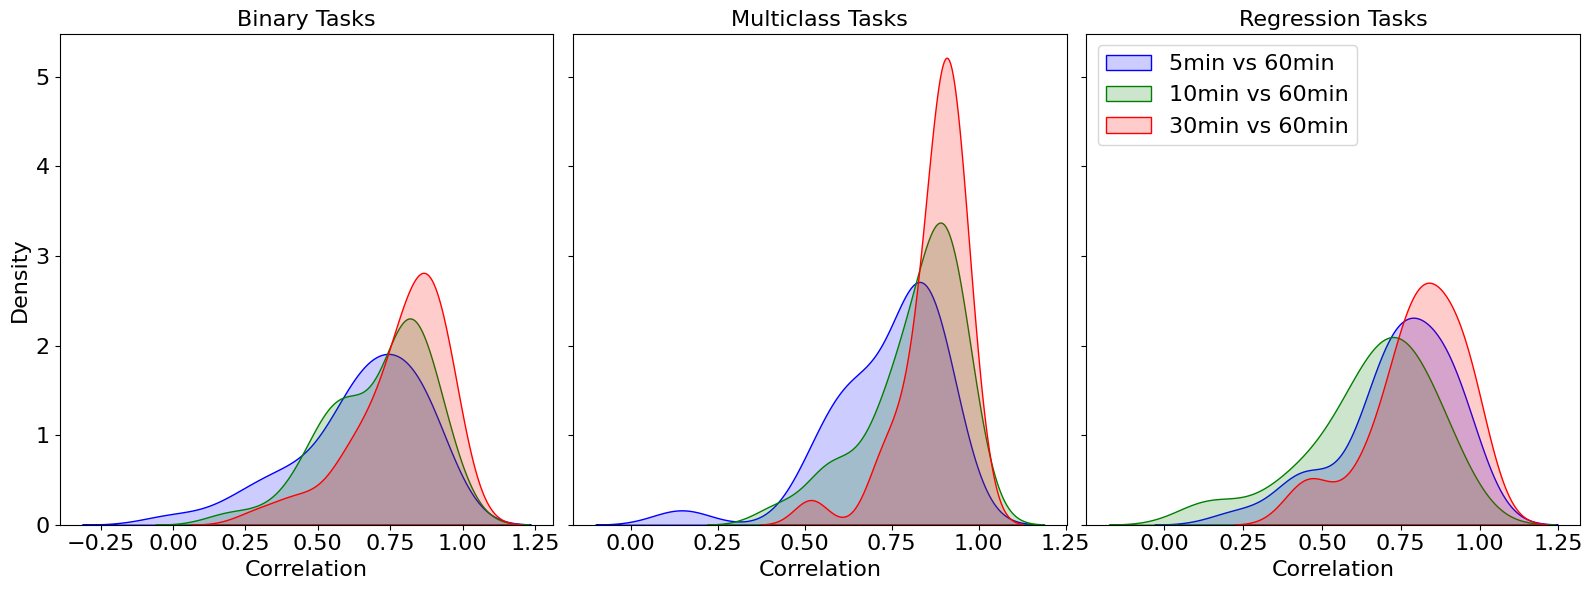

In [20]:

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

for i, (type_task, name_type) in enumerate(zip([list_binary, list_multiclass, list_regression], ['Binary', 'Multiclass', 'Regression'])):
    
    # Filter the DataFrame
    correlation_type = correlation_df[correlation_df['Task'].isin(type_task)]
    
    # Plot Density Distributions
    colors = ['blue', 'green', 'red']
    for (time1, time2), color in zip(time_pairs, colors):
        subset = correlation_type[(correlation_type['Time1'] == time1) & (correlation_type['Time2'] == time2)]
        sns.kdeplot(subset['Correlation'], fill=True, color=color, alpha=0.2, label=f'{time1} vs {time2}' if i == 2 else "", ax=axes[i])
    
    axes[i].set_title(f'{name_type} Tasks', fontsize=16)
    axes[i].set_xlabel('Correlation', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    if i == 0:
        axes[i].set_ylabel('Density', fontsize=16)
    else:
        axes[i].set_ylabel('')
    
    # Position the legend outside the plot only for the last subplot
    if i == 2:
        # axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=16)
        # axes[i].legend(bbox_to_anchor=(0.5, -0.6), loc='lower center', borderaxespad=0., fontsize=16)
        axes[i].legend(loc='upper left', fontsize=16)
        
plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY / 'density_plot_over_types.png', bbox_inches='tight', dpi=300)
plt.show()

#### Balance or not

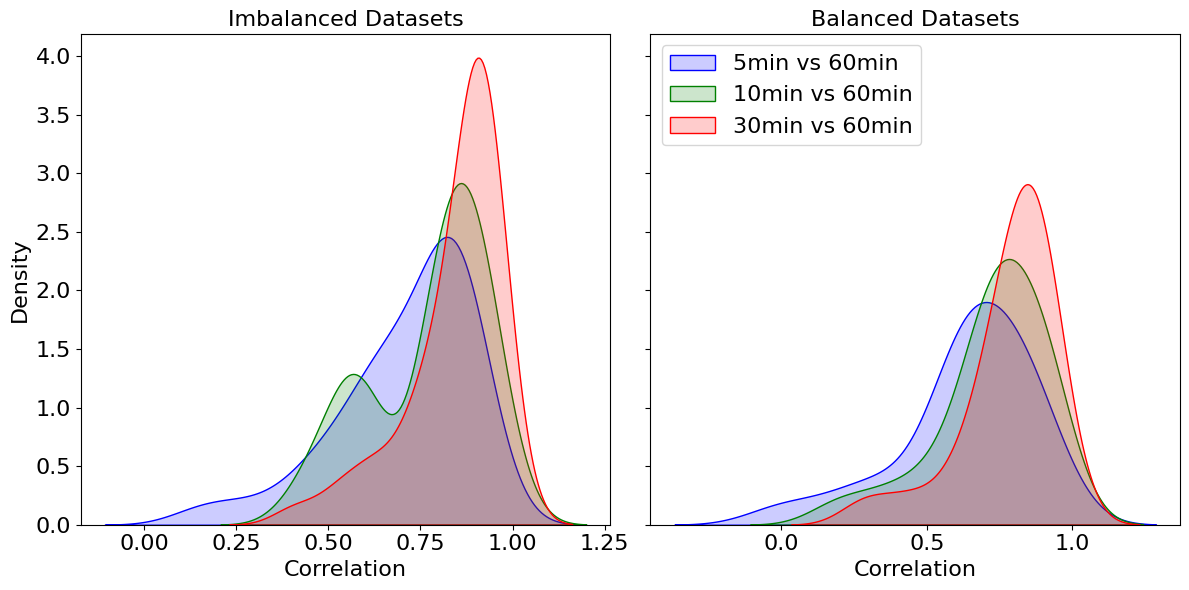

In [21]:

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for i, (type_task, name_type) in enumerate(zip([imbalance_dataset, balance_dataset], ['Imbalanced', 'Balanced'])):
    
    # Filter the DataFrame
    correlation_small = correlation_df[correlation_df['Task'].isin(type_task)]

    # Plot Density Distributions
    colors = ['blue', 'green', 'red']
    for (time1, time2), color in zip(time_pairs, colors):
        subset = correlation_small[(correlation_small['Time1'] == time1) & (correlation_small['Time2'] == time2)]
        if not subset.empty:
            sns.kdeplot(subset['Correlation'], fill=True, color=color, alpha=0.2, label=f'{time1} vs {time2}' if i == 1 else "", ax=axes[i])
    
    axes[i].set_title(f'{name_type} Datasets', fontsize=16)
    axes[i].set_xlabel('Correlation', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    if i == 0:
        axes[i].set_ylabel('Density', fontsize=16)
    else:
        axes[i].set_ylabel('')
    
    # Position the legend outside the plot only for the last subplot
    if i == 1:
        # axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=16)
        # axes[i].legend(bbox_to_anchor=(0.5, -0.6), loc='lower center', borderaxespad=0., fontsize=16)
        axes[i].legend(loc='upper left', fontsize=16)
        
plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY / 'density_plot_over_imbalances.png', bbox_inches='tight', dpi=300)
plt.show()